# Project 3: Subreddit Classification with Pushshift API and NLP

## Part II - Exploratory Data Analysis (EDA)

Author: Charles Ramey

Date: 04/02/2023

---

#### Notebook Links

Part I - Project Intro & Data Cleaning
- [`Part-1_setup-and-cleaning.ipynb`](../code/Part-1_setup-and-cleaning.ipynb)

Part III - Modeling
- [`Part-3_modeling.ipynb`](../code/Part-3_modeling.ipynb)

Part IV - Conclusion, Recommendations, and Sources
- [`Part-4_conclusion-and-recommendations.ipynb`](../code/Part-4_conclusion-and-recommendations.ipynb)

### Contents

- [Data Import and Additional Cleaning](#Data-Import-and-Additional-Cleaning)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))

## Data Import and Additional Cleaning

### Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

import warnings

### Data Import

In [2]:
df = pd.read_csv('../data/combined_text.csv')

In [3]:
df.head()

,subreddit,text
0,hockey,Does anyone know Jordan Staals take on Pride j...
1,hockey,Elimination/Clinching Scenarios + Daily Free T...
2,hockey,Is McDavid's Contract Worth It? I'm guessing h...
3,hockey,How’s the Tank for Bedard? Who’s the favourite...
4,hockey,Shayne Gostisbehere has more points than Timo ...


### More Cleaning

Before the text data can be explored, it needs to be pruned and cleaned so the submission text only contains relevant characters and words. 

NLP is used to process and understand human language, however the web markup language HTML can linger in text scraped from the web and interferes with NLP modeling. It is wise to remove HTML artifacts before removing other non-latin characters so that the latin characters from HTML markups (e.g < p>, < body>, < div>, etc.) don't remain as non-contexual characters/words.

After removing HTML, we'll perform a blanket removal of all non-latin characters and numbers. This includes non-english text such as mandarin characters, as well as emojis and other unique characters. Numbers are not anticipated to be particularly insightful with regard to which subreddit caters more to non-professional hockey, which is why they are also removed.

Lastly, the text is tokenized (broken down into individual words) and [lemmatized](https://www.techtarget.com/searchenterpriseai/definition/lemmatization#:~:text=Lemmatization%20is%20the%20process%20of,processing%20(NLP)%20and%20chatbots.). Lemmatization is performed on the text as a way of reducing the vocabulary to the roots of words. For example, the words  "skating" and "skates" have similar meanings, and a NLP model could perform more efficiently if they are both counted under the root "skate".

#### Remove HTML Code Artifacts Using Beautiful Soup

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df['text'] = df['text'].map(lambda x: BeautifulSoup(x, 'html.parser').get_text())

#### Remove Punctuation, Special Characters, and Numbers

In [5]:
df['text'] = df['text'].str.replace('[^a-zA-Z]', ' ', regex=True)

#### Tokenize and Lemmatize

In [6]:
# https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [7]:
df['text'] = df['text'].apply(LemmaTokenizer())

After lemmatizing the text, the lists of words need to be recombined into single strings to easily call words and phrases that exist anywhere in the text.

In [8]:
df['text'] = df['text'].apply(' '.join)

### Save For Modeling

This fully cleaned data will be used later for modeling, so we'll save it here so we can import it in the next notebook.

In [9]:
df.to_csv('../data/data_to_split.csv', index=False)

## Exploratory Data Analysis (EDA)


Stop words are commonly used words that do not carry much meaning on their own, think words like "the", "and", and "or". These words are filtered out to improve the efficiency and accuracy of our NLP modeling, but also help us focus on meaningful words that might help us investigate these two subreddits. There are pre-made libraries of stop words, however the list below was created through a manual, iterative process to carefully filter out common words and acronyms without removing potentially relevant words.

In [10]:
stopwords = ['the','to','and','http','www','com','in','com','of','for','it','subreddit',
             'is','on','with','that','at','this','have','but','be','en', 'pm','nd','st',
            'rd', 'if','are','so','can','from','id', 'hlslive', 'wsczoominwestus','wa',
            'jpg','pjpg','format','webp','png','doc','google','form', 's', 'link', 've']

#### Both Subreddits

Before looking at word frequencies by subreddit, let's get a baseline to compare to by looking at the language that occurs most frequenctly across both subreddits. Single words (also known as unigrams) are useful, but sometimes it is even more informative to look at word pairings and short phrases, so we'll take a look at two-word and three-word groupings as well (bigrams and trigrams, respectively).

To evaluate word frequency, we'll use the feature extraction technique, Count Vectorization, which breaks the text down into tokens again and converts the text into a matrix where each column is a token or n-gram, and each value in the column represents the number of times that token is used in that submission. By summing the rows in a column, we can determine the total number of times a word or phrase is used across all submissions.

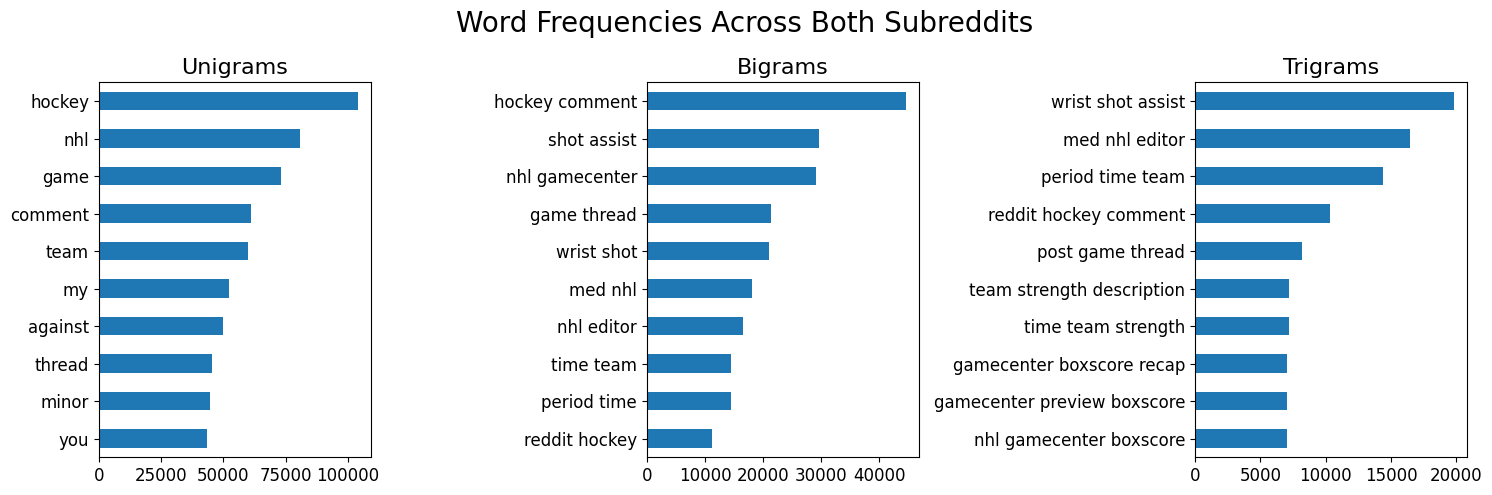

In [11]:
# Setting up subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Single words (Unigrams)
# instantiate the count vectorize for unigrams
cvec1 = CountVectorizer(max_features=1000, stop_words=stopwords, ngram_range=(1,1))
# apply the count vectorizer to the text
words1 = cvec1.fit_transform(df['text'])
# create a Pandas dataframe from the count vectorized data
# and name the columns according to the extracted words
df_words1 = pd.DataFrame(words1.toarray(), columns=cvec1.get_feature_names_out())
# plot the 10 most frequent unigrams on a horizontal barplot
df_words1.sum().nlargest(10)[-1::-1].plot(kind='barh', ax=axs[0])
axs[0].set_title('Unigrams', fontsize=16)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].tick_params(axis='x', labelsize=12)

# Two-word pairs (Bigrams)
cvec2 = CountVectorizer(max_features=1000, stop_words=stopwords, ngram_range=(2,2))
words2 = cvec2.fit_transform(df['text'])
df_words2 = pd.DataFrame(words2.toarray(), columns=cvec2.get_feature_names_out())
df_words2.sum().nlargest(10)[-1::-1].plot(kind='barh', ax=axs[1])
axs[1].set_title('Bigrams', fontsize=16)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].tick_params(axis='x', labelsize=12)

# Three-word phrases (Trigrams)
cvec3 = CountVectorizer(max_features=1000, stop_words=stopwords, ngram_range=(3,3))
words3 = cvec3.fit_transform(df['text'])
df_words3 = pd.DataFrame(words3.toarray(), columns=cvec3.get_feature_names_out())
df_words3.sum().nlargest(10)[-1::-1].plot(kind='barh', ax=axs[2])
axs[2].set_title('Trigrams', fontsize=16)
axs[2].tick_params(axis='y', labelsize=12)
axs[2].tick_params(axis='x', labelsize=12)

# fig.text(0.5, 0, 'Frequency', ha='center', fontsize=14)
fig.suptitle('Word Frequencies Across Both Subreddits', fontsize=20)
plt.tight_layout()

As we might have expected, "hockey" is the most common word used across these two hockey-centric subreddits. Of particular interest are mentions of the "NHL", the foremost professional hockey league in the United States and Canada. We will want to explore this more to find out which subreddit sees greater use of the term "NHL". We do begin to get a little more context with bigrams and trigrams, however most of these phrases seem to make reference to professional hockey. Next, we'll look at word frequency by subreddit to try to get a clearer picture of which words and phrases are more represented in one subreddit vs. the other. To do this, we'll focus on different n-grams and group the results by subreddit.

In [12]:
# count vectorized dataframes by differnent n-grams are concatenated with
# the main dataframe so the results can be grouped by subreddit
unigrams = pd.concat((df, df_words1), axis=1)
bigrams = pd.concat((df, df_words2), axis=1)
trigrams = pd.concat((df, df_words3), axis=1)

#### Unigrams by Subreddit

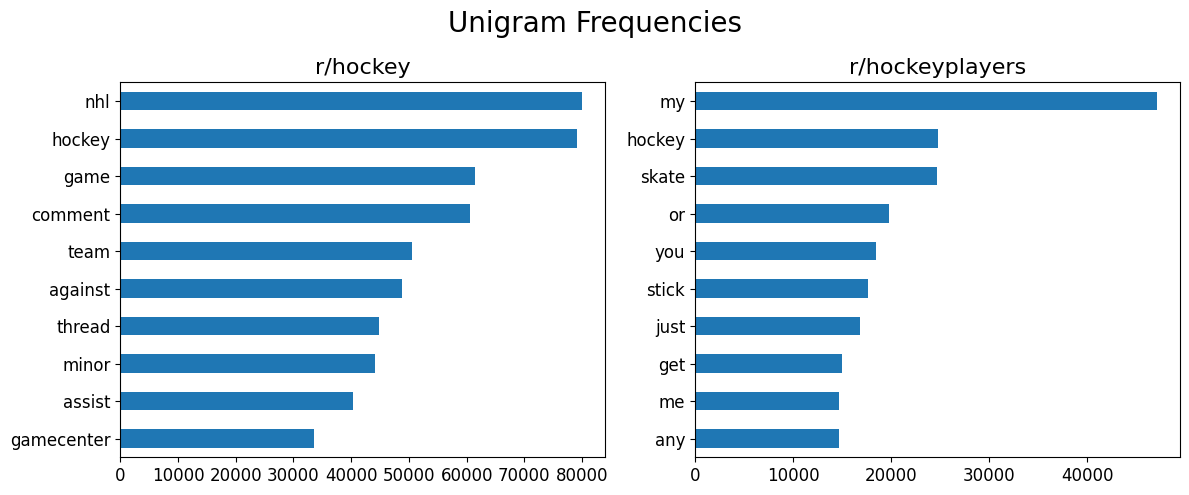

In [13]:
# Setting up subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

unigrams[unigrams['subreddit'] == 'hockey'].drop(columns=df.columns).sum().nlargest(10)[-1::-1].plot(kind='barh', ax=axs[0])
axs[0].set_title('r/hockey', fontsize=16)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].tick_params(axis='x', labelsize=12)

unigrams[unigrams['subreddit'] == 'hockeyplayers'].drop(columns=df.columns).sum().nlargest(10)[-1::-1].plot(kind='barh', ax=axs[1])
axs[1].set_title('r/hockeyplayers', fontsize=16)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].tick_params(axis='x', labelsize=12)

fig.suptitle('Unigram Frequencies', fontsize=20)
plt.tight_layout()

By grouping common words by subreddit, we are now seeing some distinction between the two subreddits. The only shared word among the top 10 unigrams for each subreddit is "hockey". We'll want a little more context for these words to try to really understand each subreddit. Let's take a look at the common bigrams and trigrams.

#### Bigrams by Subreddit

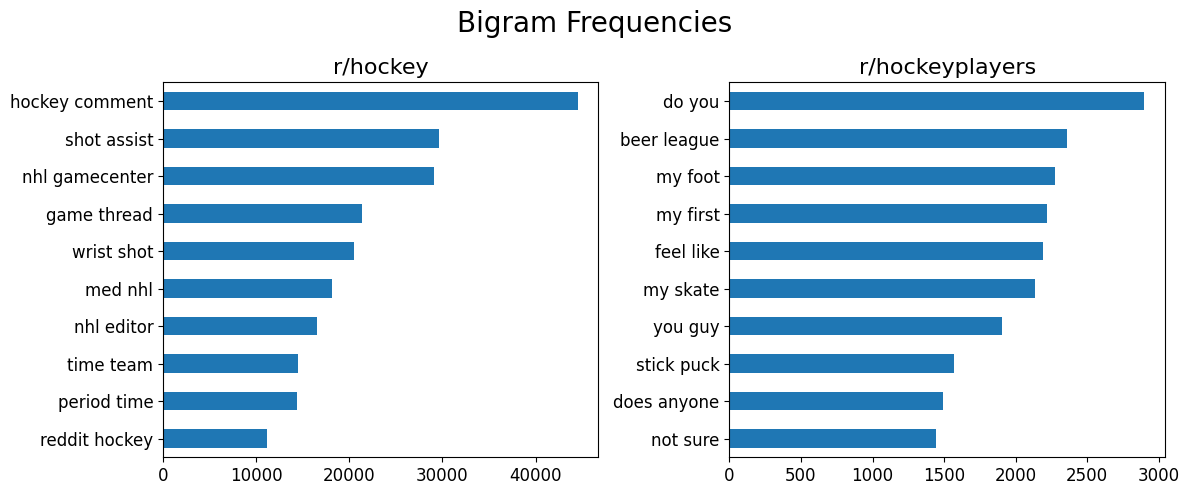

In [ ]:
# Setting up subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

bigrams[bigrams['subreddit'] == 'hockey'].drop(columns=df.columns).sum().nlargest(10)[-1::-1].plot(kind='barh', ax=axs[0])
axs[0].set_title('r/hockey', fontsize=16)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].tick_params(axis='x', labelsize=12)

bigrams[bigrams['subreddit'] == 'hockeyplayers'].drop(columns=df.columns).sum().nlargest(10)[-1::-1].plot(kind='barh', ax=axs[1])
axs[1].set_title('r/hockeyplayers', fontsize=16)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].tick_params(axis='x', labelsize=12)

fig.suptitle('Bigram Frequencies', fontsize=20)
plt.tight_layout()

The bigrams provide a little more context, and we're starting to see some word pairings that indicate that r/hockeyplayers is likely to be the target audience for a hockey equipment marketing campaign. Not only are there fewer references to the nhl and game metrics like shots and time, there are more references to the individual ("my foot", "my first", "my skate"). It's also interesting to see the emergence of the term "beer league", which is a term exclusively used in reference to non-professional hockey leagues, those in which most casual hockey players are likely to participate in (beer or no beer).

#### Trigrams by Subreddit

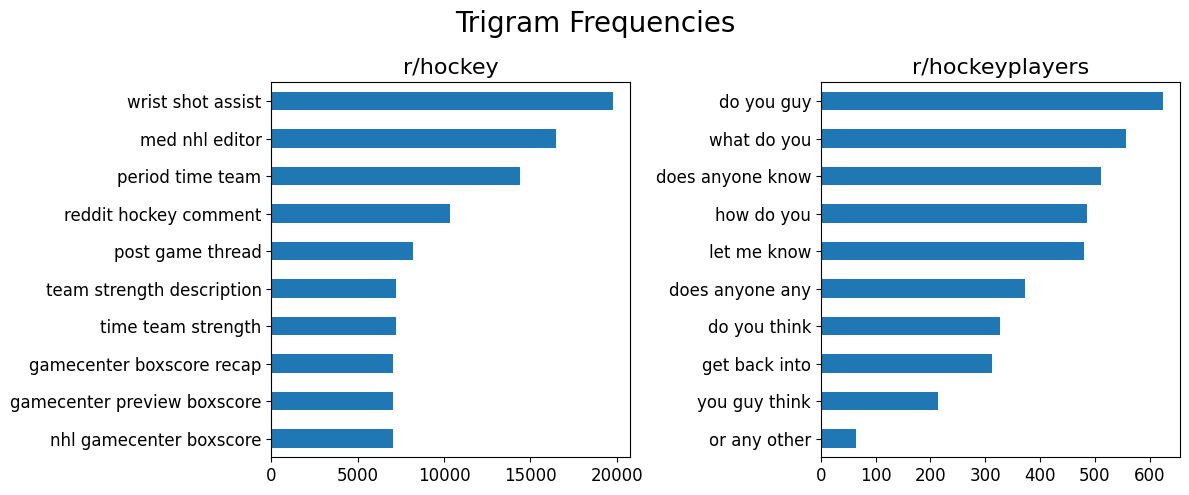

In [15]:
# Setting up subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

trigrams[trigrams['subreddit'] == 'hockey'].drop(columns=df.columns).sum().nlargest(10)[-1::-1].plot(kind='barh', ax=axs[0])
axs[0].set_title('r/hockey', fontsize=16)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].tick_params(axis='x', labelsize=12)

trigrams[trigrams['subreddit'] == 'hockeyplayers'].drop(columns=df.columns).sum().nlargest(10)[-1::-1].plot(kind='barh', ax=axs[1])
axs[1].set_title('r/hockeyplayers', fontsize=16)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].tick_params(axis='x', labelsize=12)

fig.suptitle('Trigram Frequencies', fontsize=20)
plt.tight_layout()

Trigrams are giving us a lot of info and context. In particular, we're seeing a lot more language in r/hockeyplayers that is indicative of newer players seeking advice ("do you guy", "what do you", "does anyone know", etc.). From a markerting standpoint, this language amay also point to a user base that could be seeking equipment recommendations. For example, it would not be a stretch to expect phrasing like "does anyone know where I can get an affordable, high-quality pair of hockey skates?" Another potentially valuable insight we can gain from this, is that r/hockeyplayers seems to be a hub for former players looking to "get back into" the sport. This demographic would fall directly into the target audience, as former players may no long have or fit into their old equipment, and could be interested in acquiring new, affordable gear.

---

Let's dive a little deeper into some of patterns that have been revealed up to this point. Let's start with the terms "NHL" and "Beer League". These terms should be highly indicative of the target audience, as they represent different ends of the player skill spectrum, with "Beer League" acting as a proxy for beginner or more senior hockey players that would be in greater need of low-cost hockey equipment.

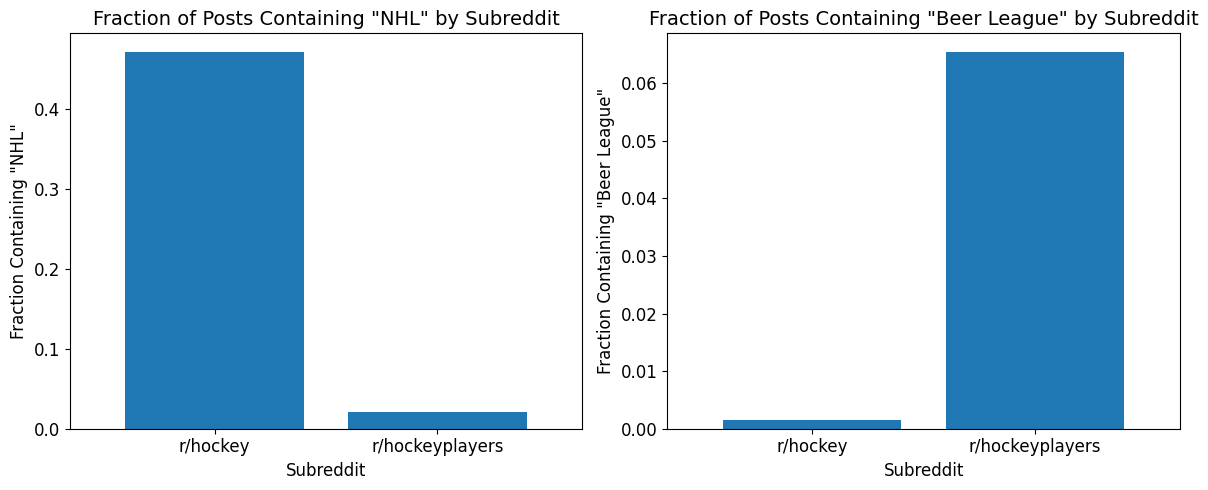

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

df['text'].str.contains('nhl', case=False).groupby(df['subreddit']).mean().plot.bar(
    ax=axs[0], rot=0, width=0.8
)
axs[0].set_title('Fraction of Posts Containing "NHL" by Subreddit', fontsize=14)
axs[0].set_xlabel('Subreddit', fontsize=12)
axs[0].set_ylabel('Fraction Containing "NHL"', fontsize=12)
axs[0].set_xticklabels(['r/hockey','r/hockeyplayers'])
axs[0].tick_params(axis='y', labelsize=12)
axs[0].tick_params(axis='x', labelsize=12)

df['text'].str.contains('beer league', case=False).groupby(df['subreddit']).mean().plot.bar(
    ax=axs[1], rot=0, width=0.8
)
axs[1].set_title('Fraction of Posts Containing "Beer League" by Subreddit', fontsize=14)
axs[1].set_xlabel('Subreddit', fontsize=12)
axs[1].set_ylabel('Fraction Containing "Beer League"', fontsize=12)
axs[1].set_xticklabels(['r/hockey','r/hockeyplayers'])
axs[1].tick_params(axis='y', labelsize=12)
axs[1].tick_params(axis='x', labelsize=12)

plt.tight_layout()

Consistent with what we saw in the bar plots of common n-grams, we see a distint difference in hte usage of these two terms between r/hockey and r/hockeyplayers. Submissions in r/hockeyplayers do contain some references to the NHL, though the key indicator here is the rate of usage relative to the other subreddit. The subreddit r/hockey clearly caters more to professional hockey content.

Of course, common sense would suggest that those who play hockey are also likely to be fans of professional hockey. So we might ask, is it possible that non-professional players may still be discussing questions about personal hockey equipment in r/hockey? Let's look at frequency of references to the user's own equipment, in particular two of the most important pieces of equipment, their skates and hockey stick.

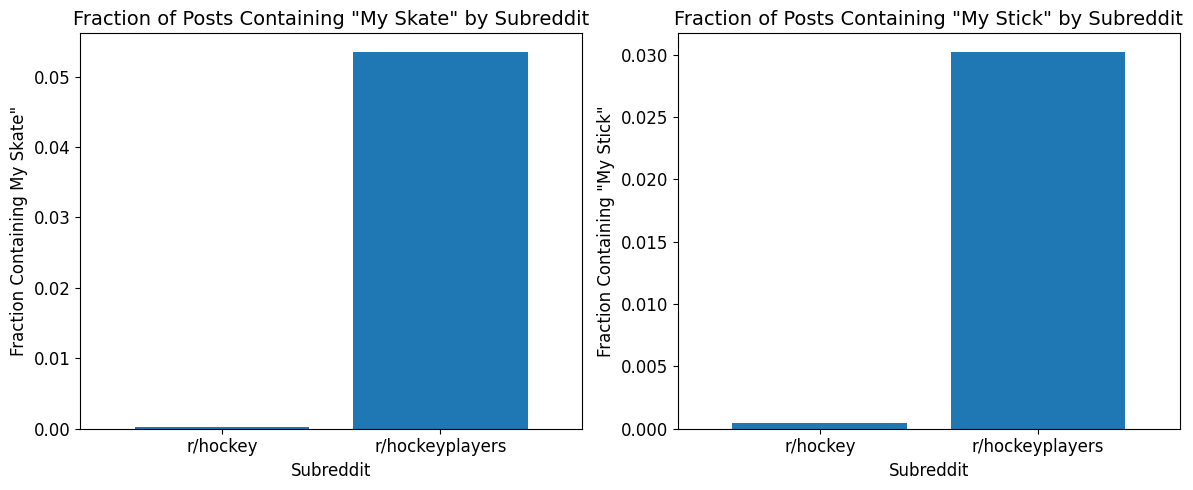

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

df['text'].str.contains('my skate', case=False).groupby(df['subreddit']).mean().plot.bar(
    ax=axs[0], rot=0, width=0.8
)
axs[0].set_title('Fraction of Posts Containing "My Skate" by Subreddit', fontsize=14)
axs[0].set_xlabel('Subreddit', fontsize=12)
axs[0].set_ylabel('Fraction Containing My Skate"', fontsize=12)
axs[0].set_xticklabels(['r/hockey','r/hockeyplayers'])
axs[0].tick_params(axis='y', labelsize=12)
axs[0].tick_params(axis='x', labelsize=12)

df['text'].str.contains('my stick', case=False).groupby(df['subreddit']).mean().plot.bar(
    ax=axs[1], rot=0, width=0.8
)
axs[1].set_title('Fraction of Posts Containing "My Stick" by Subreddit', fontsize=14)
axs[1].set_xlabel('Subreddit', fontsize=12)
axs[1].set_ylabel('Fraction Containing "My Stick"', fontsize=12)
axs[1].set_xticklabels(['r/hockey','r/hockeyplayers'])
axs[1].tick_params(axis='y', labelsize=12)
axs[1].tick_params(axis='x', labelsize=12)

plt.tight_layout()

Not only do these phrases appear significantly more often in r/hockeyplayers, they are almost non-existent in r/hockey, with the fraction of posts containing these words hovering just above zero.

HFE doesn't just want to provide equipment for the experience player and those looking to get back into hockey after a long time away. One of the key target demographics are those players who are new to the sport, where a common barrier to entry can be the cost of hockey equipment. Let's take a look at the use of a couple terms that may represent this group of people, "learn" and "new player".

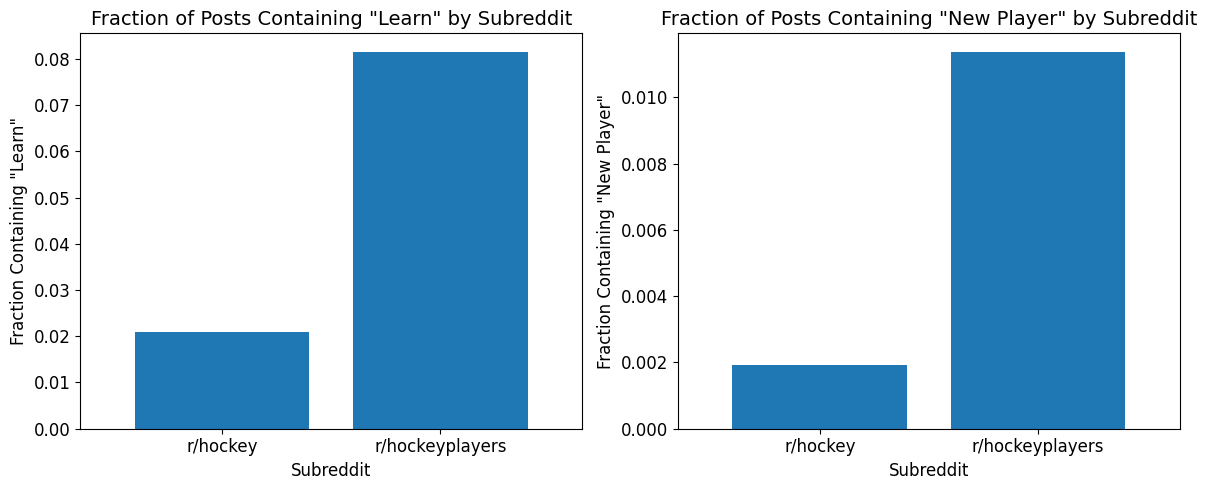

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

df['text'].str.contains('learn', case=False).groupby(df['subreddit']).mean().plot.bar(
    ax=axs[0], rot=0, width=0.8
)
axs[0].set_title('Fraction of Posts Containing "Learn" by Subreddit', fontsize=14)
axs[0].set_xlabel('Subreddit', fontsize=12)
axs[0].set_ylabel('Fraction Containing "Learn"', fontsize=12)
axs[0].set_xticklabels(['r/hockey','r/hockeyplayers'])
axs[0].tick_params(axis='y', labelsize=12)
axs[0].tick_params(axis='x', labelsize=12)

df['text'].str.contains('new player', case=False).groupby(df['subreddit']).mean().plot.bar(
    ax=axs[1], rot=0, width=0.8
)
axs[1].set_title('Fraction of Posts Containing "New Player" by Subreddit', fontsize=14)
axs[1].set_xlabel('Subreddit', fontsize=12)
axs[1].set_ylabel('Fraction Containing "New Player"', fontsize=12)
axs[1].set_xticklabels(['r/hockey','r/hockeyplayers'])
axs[1].tick_params(axis='y', labelsize=12)
axs[1].tick_params(axis='x', labelsize=12)

plt.tight_layout()

These terms do appear in r/hockey, though we may infer from our analysis to this point that they may be used in the context of professional hockey. For example, we might see a fan say something like "Team A needs to learn how to maintain a lead in the third period", or a post discussion a team's free agent acquisiton, "Team B has a new player in town after signing Player C". Based on what we've learned about these two subreddits, we expect to see these terms used more in the following context: "I want to learn to play hockey, but I'm not sure where to begin" or as a submission title, "New Player, Need Advice."

In Part III, we'll start building a machine learning model to accurately classify submissions into the appropriate subreddit. This tool can help HFE to draft Reddit marketing language that suits its advertising to the target audience.

---
#### Notebook Links

Part I - Project Intro & Data Cleaning
- [`Part-1_setup-and-cleaning.ipynb`](../code/Part-1_setup-and-cleaning.ipynb)

Part III - Modeling
- [`Part-3_modeling.ipynb`](../code/Part-3_modeling.ipynb)

Part IV - Conclusion, Recommendations, and Sources
- [`Part-4_conclusion-and-recommendations.ipynb`](../code/Part-4_conclusion-and-recommendations.ipynb)